# About this Notebook:

Here we aim to build a best performing model.We will be exploring:
1. Different choice of model (e.g. Random Forest)
1. Include Stemming/Lemitisation during preprocessing
1. Apply conditions such as *min_df* and *max_df* during vectorisation
1. Attempt using TFIDF vs CountVectorizer
1. Attempt searching for Bigrams


# Loads and imports

In [69]:
import numpy as np 
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


#Visualisation:
import seaborn               as sns
import matplotlib.pyplot     as plt
sns.set_theme(style="whitegrid")


from tqdm import tqdm
tqdm.pandas()

#Showing missing, duplicates, shape, dtypes
def df_summary(df):
    print(f"Shape(col,rows): {df.shape}")
    print(f"Number of duplicates: {df.duplicated().sum()}")
    print('---'*20)
    print(f'Number of each unqiue datatypes:\n{df.dtypes.value_counts()}')
    print('---'*20)
    print("Columns with missing values:")
    isnull_df = pd.DataFrame(df.isnull().sum()).reset_index()
    isnull_df.columns = ['col','num_nulls']
    isnull_df['perc_null'] = ((isnull_df['num_nulls'])/(len(df))).round(2)
    print(isnull_df[isnull_df['num_nulls']>0])

#Preprocessing
from nltk.stem.porter import PorterStemmer

#Vectorizing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#Modelling
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

#Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import make_scorer

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score #sensitivity
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report #precision+recall+f1-score

In [2]:
#return all scoring results:
def fit_score_(model):
    print(f"y_train:\n{y_train.value_counts(normalize=True)}\n")
    print(f"y_test:\n{y_test.value_counts(normalize=True)}\n")
 
    
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print(f"Train accuracy score:{model.score(X_train, y_train)}")
    print(f"Test accuracy score:{model.score(X_test, y_test)}")
    print(f"Train f1 score:{f1_score(y_train, y_train_pred)}")
    print(f"Test f1 score:{f1_score(y_test, y_test_pred)}")
    print("\n")
    print(classification_report(y_test, y_test_pred))
    print("\n")
    
    cm = confusion_matrix(y_test, y_test_pred) 
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Poor Games','Good games']).plot(cmap='Blues')
    plt.show();
    

In [3]:
df = pd.read_csv("cleaned_dataset.csv")
df['Good_Game'] = df['Good_Game'].astype(int)
df_summary(df)
df.dtypes

Shape(col,rows): (27309, 12)
Number of duplicates: 0
------------------------------------------------------------
Number of each unqiue datatypes:
object     6
int64      4
float64    1
int32      1
dtype: int64
------------------------------------------------------------
Columns with missing values:
Empty DataFrame
Columns: [col, num_nulls, perc_null]
Index: []


title                   object
r_date                  object
price                  float64
description             object
review_type             object
review_stats            object
positive_percentage      int64
total_reviews            int64
tagged                  object
game_id                  int64
Good_Game                int32
r_year                   int64
dtype: object

# Approach 1: Explore Random Forests

**Description of Approach 1**:
*Mainly keeping all consistent, but apply different model*
- Preprocessing:
    - Use CountVectorizer, limit feautres to 1500 and remove StopWords
- Model: Random Forests

## Model Preprocessing

In [39]:
_df = df.copy()

X = _df['description']
y = _df['Good_Game']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, stratify=y) 

print(f"y_train:")
y_train.value_counts(normalize=True)
print("\n")
print(f"y_test:")
y_test.value_counts(normalize=True)
print("\n")

cvec = CountVectorizer(stop_words = 'english',max_features=1500)

X_train = cvec.fit_transform(X_train)
X_train = pd.DataFrame(X_train.toarray(),
                       columns = cvec.get_feature_names_out())

X_test = cvec.transform(X_test)
X_test = pd.DataFrame(X_test.toarray(),
                      columns = cvec.get_feature_names_out())

## Model Fitting and Assessment

Train accuracy score:0.9043015477759875
Test accuracy score:0.7246631517281781
Train f1 score:0.937746156778046
Test f1 score:0.837986901068597


              precision    recall  f1-score   support

       False       0.58      0.05      0.08      1904
        True       0.73      0.99      0.84      4924

    accuracy                           0.72      6828
   macro avg       0.65      0.52      0.46      6828
weighted avg       0.69      0.72      0.63      6828





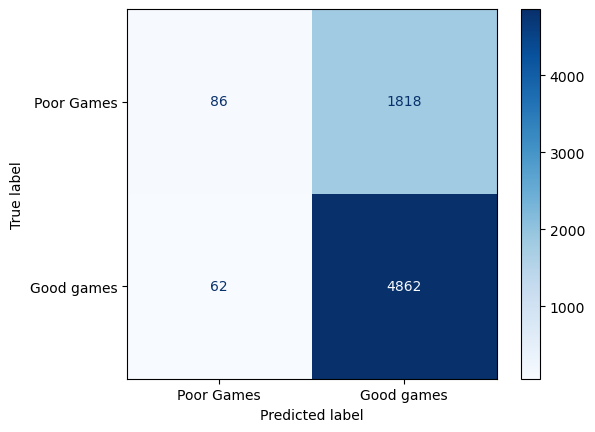

In [39]:
rf = RandomForestClassifier(max_depth=50)
fit_score_(rf)

**Comments:**

|Model|Description|Performance|
|---|---|---|
|Baseline Model<br>Multinomial Naive Bayes|Processes:<br> CountVectorizer<br>(stop_words = 'english',<br>max_features=1500)|<li>Score to beat: 72% <li> Model Precision score: 79%|
|Approach 1:<br>Random Forest|Processes:<br> CountVectorizer<br>(stop_words = 'english',<br>max_features=1500)|<li>Score to beat: 72% <li> Model Precision score: 73%|


Random Forest appeat to give poorer model performance compared to our baseline model (Multinomial Naive Bayes(MNB)).
- It has a precision score of 0.73 (vs 0.79).

> Let's further improve the performance of MNB by trying different vectorizers to select the terms used for modelling. 

# *Before we continue: Lets implement Stemming in Model Processing:*

In [5]:
stemmer = PorterStemmer()

def stem_text(text):
    return stemmer.stem(text)

df['description'] = df['description'].apply(stem_text)

# Approach 2: Explore different Vectorizers and parameters
> By adjusting the parameters of Count Vectoriser, we explore how the model classification performance through the different set of terms used for differentiating 'Good' and 'Poor' games

- Preprocessing:
    - CountVectorizer
    - TfidfVectorizer
    - varying parameters
- Model: Multinomial Naive Bayes

## Approach 2.1 - defining the different Vectorizers to explore

In [6]:
#cvec 1 and 2 aims to limit terms by excluding terms that are too frequent and terms that appeared too less frequent
cvec_1 = CountVectorizer(stop_words = 'english',
                       max_features=1500,
                      max_df=0.5,
                      min_df = 0.05)

cvec_2 = CountVectorizer(stop_words = 'english',
                       max_features=1500,
                      max_df=0.3,
                      min_df = 0.05)

#cvec 3 and 4 aims to explore bigrams and trigrams
cvec_3 = CountVectorizer(stop_words = 'english',
                       max_features=1500,
                      ngram_range=(2,2))

cvec_4 = CountVectorizer(stop_words = 'english',
                       max_features=1500,
                      ngram_range=(2,3))

#TFIDF is also explored (using ) 
tvec_1 = TfidfVectorizer(stop_words = 'english',
                       max_features=1500,
                      max_df=0.5)

tvec_2 = TfidfVectorizer(stop_words = 'english',
                       max_features=1500,
                       min_df=0.01,
                      ngram_range=(2,3))

In [7]:
#Putting the different vectorizer in a list
vec_ls = [cvec_1,cvec_2,cvec_3,cvec_4,tvec_1,tvec_2]


## Approach 2.2 - Applying the different Vectorizers, and evaluate model's performance

In [9]:
## lets obtain the precision score using these different vectorisers:
number = 0

for vec in vec_ls:
    _df = df.copy()

    X = _df['description']
    y = _df['Good_Game']

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, stratify=y) 

    X_train = vec.fit_transform(X_train)
    X_train = pd.DataFrame(X_train.toarray(),
                           columns = vec.get_feature_names_out())

    X_test = vec.transform(X_test)
    X_test = pd.DataFrame(X_test.toarray(),
                          columns = vec.get_feature_names_out())

    nb = MultinomialNB()
    nb.fit(X_train, y_train)
    y_pred = nb.predict(X_test)   
    print(f"Precision score for {vec_name[number]} is {precision_score(y_test, y_pred)}")
    
    number = number + 1

MultinomialNB()

Precision score for cvec_1 is 0.760686951652044


MultinomialNB()

Precision score for cvec_2 is 0.7614678899082569


MultinomialNB()

Precision score for cvec_3 is 0.7514245014245015


MultinomialNB()

Precision score for cvec_4 is 0.7556287753981329


MultinomialNB()

Precision score for tvec_1 is 0.7269339692949769


MultinomialNB()

Precision score for tvec_2 is 0.7212538450270983


**Comments**

These precision scores are generally poorer than that of our baseline model (0.79), which is not desirable to our stakeholders.

|Model|Description|Performance|
|---|---|---|
|Baseline Model<br>Multinomial Naive Bayes|Processes:<br> CountVectorizer<br>(stop_words = 'english',<br>max_features=1500)|<li>Score to beat: 72% <li> Model Precision score: 79%|
|Approach 1:<br>Random Forest|Processes:<br> CountVectorizer<br>(stop_words = 'english',<br>max_features=1500)|<li>Score to beat: 72% <li> Model Precision score: 73%|
|Approach 2:<br>Multinomial Naive Bayes<br>varying Vectorizer used|Processes:<br> CountVectorizer<br>TfidfVectorizer|<li>Score to beat: 72% <li> Models Precision score 72-76%|

# Approach 3: Explore different vectorizers with game with at least 50 reviews.

**Rationale**:<br> 
- Good Games are defined as games with more than 70% positive reviews. 
- However, there are games with small number of reviews, raising concern whether labelling as such is accurate. 

> We shall now explore how the model (MNB) perform when we only include games with minimum 50 reviews.
> With smaller dataset, we are able to expand our max_features to a larger number while still performing within our computer's limit.

In [10]:
games_atlst50revw_df = df.loc[df['total_reviews']>=50,:]
len(games_atlst50revw_df)
games_atlst50revw_df['Good_Game'].value_counts(normalize=True)

10429

1    0.776009
0    0.223991
Name: Good_Game, dtype: float64

## **Note: New Precision Target**
- Now that we filter out games with <50 reviews, the new sample have 77.6% 'Good Games'.
- Now, in other words, the model has to aim for precision much better than 77.6%

In [11]:
cvec_uniG = CountVectorizer(stop_words = 'english',
                       max_features=10000,
                      max_df=0.5,
                      min_df = 0.05)

cvec_biG = CountVectorizer(stop_words = 'english',
                           ngram_range=(2, 2),
                           max_features=10000,
                           min_df=0.01)

cvec_biG_triG = CountVectorizer(stop_words = 'english',
                         ngram_range=(2, 3),
                         max_features=10000,
                         min_df=0.01)

cvec_uniG_biG = CountVectorizer(stop_words = 'english',
                                ngram_range=(1, 2),
                                max_features=10000,
                                max_df=0.5,
                                min_df=0.01)

tvec_uniG = TfidfVectorizer(stop_words = 'english',
                       max_features=10000,
                      max_df=0.5,
                      min_df = 0.05)

tvec_uniG_biG = TfidfVectorizer(stop_words = 'english',
                                ngram_range=(1, 2),
                                max_features=10000,
                                max_df=0.5,
                                min_df=0.01)

vec_ls = [cvec_uniG,
              cvec_biG,
              cvec_biG_triG,
              cvec_uniG_biG,
              tvec_uniG,
              tvec_uniG_biG]
vec_name= ['cvec_uniG',
 'cvec_biG',
 'cvec_biG_triG',
 'cvec_uniG_biG',
 'tvec_uniG',
 'tvec_uniG_biG']

number = 0

for vec in vec_ls:
    _df = games_atlst50revw_df.copy()

    X = _df['description']
    y = _df['Good_Game']

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, stratify=y) 

    X_train = vec.fit_transform(X_train)
    X_train = pd.DataFrame(X_train.toarray(),
                           columns = vec.get_feature_names_out())

    X_test = vec.transform(X_test)
    X_test = pd.DataFrame(X_test.toarray(),
                          columns = vec.get_feature_names_out())

    nb = MultinomialNB()
    nb.fit(X_train, y_train)
    y_pred = nb.predict(X_test)   
    print(f"Precision score for {vec_name[number]} is {precision_score(y_test, y_pred)}")
    
    number = number + 1

MultinomialNB()

Precision score for cvec_uniG is 0.8127208480565371


MultinomialNB()

Precision score for cvec_biG is 0.7767369242779079


MultinomialNB()

Precision score for cvec_biG_triG is 0.7767369242779079


MultinomialNB()

Precision score for cvec_uniG_biG is 0.8342391304347826


MultinomialNB()

Precision score for tvec_uniG is 0.7760736196319018


MultinomialNB()

Precision score for tvec_uniG_biG is 0.7797987616099071


**Comments**<br>
- CountVectorizer generally performed better than TFIDFVectorizer.

- Using <code>cvec_uniG_biG</code> seemed to gave the best precision score of 0.83 (~5% improvement from 77% (default percentage of 'Good Games' in the sample). 
> However the improvement (5%) appear to be lesser than the improvement achieved by baseline MNB (*7% improvement from 0.72 to 0.79 as seen in the previous notebook*).

|Model|Description|Performance|
|---|---|---|
|Baseline Model<br>Multinomial Naive Bayes|Processes:<br> CountVectorizer<br>(stop_words = 'english',<br>max_features=1500)|<li>Score to beat: 72% <li> Model Precision score: 79%|
|Approach 1:<br>Random Forest|Processes:<br> CountVectorizer<br>(stop_words = 'english',<br>max_features=1500)|<li>Score to beat: 72% <li> Model Precision score: 73%|
|Approach 2:<br>Multinomial Naive Bayes<br>varying Vectorizer used|Processes:<br> CountVectorizer<br>TfidfVectorizer|<li>Score to beat: 72% <li> Models Precision score 72-76%|
|Approach 3:<br>Multinomial Naive Bayes<br>varying Vectorizer used<br> Limited to datasets with minimally 50 reviews|Processes:<br> CountVectorizer<br>TfidfVectorizer|<li>Score to beat: 77% <li> Models Precision score 77-83%|

<br><br><br>

**Let's view model performance in detail with <code>cvec_uniG_biG</code>**:

y_train:
1    0.775988
0    0.224012
Name: Good_Game, dtype: float64

y_test:
1    0.776074
0    0.223926
Name: Good_Game, dtype: float64

Train accuracy score:0.7211354046797085
Test accuracy score:0.6955521472392638
Train f1 score:0.8107263733402759
Test f1 score:0.7945134575569358


              precision    recall  f1-score   support

           0       0.36      0.48      0.41       584
           1       0.83      0.76      0.79      2024

    accuracy                           0.70      2608
   macro avg       0.60      0.62      0.60      2608
weighted avg       0.73      0.70      0.71      2608





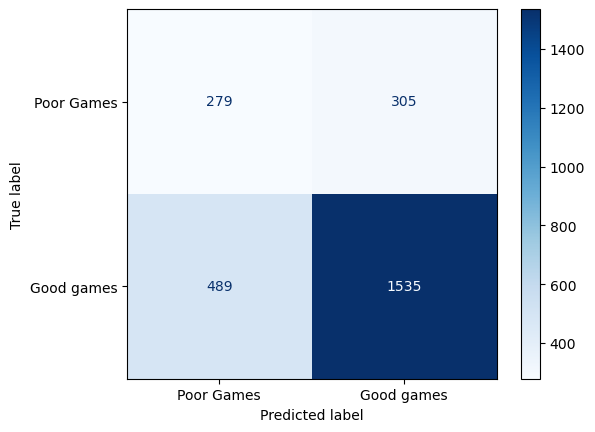

In [12]:
_df = games_atlst50revw_df.copy()

X = _df['description']
y = _df['Good_Game']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, stratify=y) 

X_train = cvec_uniG_biG.fit_transform(X_train)
X_train = pd.DataFrame(X_train.toarray(),
                       columns = cvec_uniG_biG.get_feature_names_out())

X_test = cvec_uniG_biG.transform(X_test)
X_test = pd.DataFrame(X_test.toarray(),
                      columns = cvec_uniG_biG.get_feature_names_out())
fit_score_(nb)

**Comments**

From the confusion matrix, it appears that its False Positive can be further improved.

# Approach 4: Selecting NGrams terms found in Games Descriptions

The aim is to filter out NGrams that are commonly found in 'Good' and 'Poor' games'.
> By doing so, we hope to improve model ability to differentiate 'Good' and 'Poor' game.
> Note at this point we are still using the games_atlst50revw_df(games with minimum 50 reviews)

## 4.1 Obtaining the top common NGrams from Good and Poor Games:
>Unigrams, Bigrams and Trigrams

In [13]:
games_atlst50revw_df.shape

(10429, 12)

In [14]:
#Unigram:
cvec= CountVectorizer(stop_words = 'english',ngram_range=(1, 1),
                       max_features=10000,max_df=0.5, min_df=0.01)

_df = games_atlst50revw_df.copy()
X = _df['description']
y = _df['Good_Game']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, stratify=y) 

for i in [X_train, X_test, y_train, y_test]:
    i.reset_index(inplace=True, drop=True)

X_train = cvec.fit_transform(X_train)
X_train = pd.DataFrame(X_train.toarray(),
                       columns = cvec.get_feature_names_out())

X_test = cvec.transform(X_test)
X_test = pd.DataFrame(X_test.toarray(),
                      columns = cvec.get_feature_names_out())

Xy_train = X_train.join(y_train)

df_good = Xy_train.loc[Xy_train['Good_Game']==1,list(Xy_train.columns[:-1])]
df_poor = Xy_train.loc[Xy_train['Good_Game']==0,list(Xy_train.columns[:-1])]

goodG_top100W = df_good.sum().round().sort_values(ascending=False).head(100)
poorG_top100W = df_poor.sum().round().sort_values(ascending=False).head(100)

goodG_top100W = set(goodG_top100W.index.tolist())
poorG_top100W = set(poorG_top100W.index.tolist())


Common_100_UniG = goodG_top100W|poorG_top100W
print(f"Unigrams in both Good Games & Poor Games Top 100 Unigrams ({len(Common_100_UniG)} of them)")
Common_100_UniG

Unigrams in both Good Games & Poor Games Top 100 Unigrams (120 of them)


{'abilities',
 'able',
 'action',
 'adventure',
 'art',
 'attack',
 'based',
 'battle',
 'battles',
 'beautiful',
 'best',
 'build',
 'challenge',
 'change',
 'character',
 'characters',
 'choose',
 'city',
 'classic',
 'collect',
 'combat',
 'come',
 'complete',
 'content',
 'control',
 'create',
 'dark',
 'day',
 'different',
 'discover',
 'dont',
 'enemies',
 'enemy',
 'enjoy',
 'equipment',
 'events',
 'experience',
 'explore',
 'features',
 'fight',
 'free',
 'friends',
 'fun',
 'gameplay',
 'games',
 'good',
 'great',
 'help',
 'heroes',
 'including',
 'items',
 'join',
 'journey',
 'just',
 'learn',
 'level',
 'levels',
 'life',
 'like',
 'long',
 'love',
 'main',
 'make',
 'map',
 'mode',
 'modes',
 'monsters',
 'multiplayer',
 'music',
 'mysterious',
 'need',
 'new',
 'online',
 'open',
 'order',
 'original',
 'people',
 'place',
 'play',
 'player',
 'players',
 'power',
 'powerful',
 'puzzle',
 'puzzles',
 'real',
 'resources',
 'right',
 'save',
 'set',
 'skills',
 'space',


In [15]:
#Bigram:
cvec= CountVectorizer(stop_words = 'english',ngram_range=(2, 2),
                       max_features=10000,max_df=0.5, min_df=0.01)

_df = games_atlst50revw_df.copy()
X = _df['description']
y = _df['Good_Game']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, stratify=y) 

for i in [X_train, X_test, y_train, y_test]:
    i.reset_index(inplace=True, drop=True)

X_train = cvec.fit_transform(X_train)
X_train = pd.DataFrame(X_train.toarray(),
                       columns = cvec.get_feature_names_out())

X_test = cvec.transform(X_test)
X_test = pd.DataFrame(X_test.toarray(),
                      columns = cvec.get_feature_names_out())

Xy_train = X_train.join(y_train)

df_good = Xy_train.loc[Xy_train['Good_Game']==1,list(Xy_train.columns[:-1])]
df_poor = Xy_train.loc[Xy_train['Good_Game']==0,list(Xy_train.columns[:-1])]

goodG_top100W = df_good.sum().round().sort_values(ascending=False).head(100)
poorG_top100W = df_poor.sum().round().sort_values(ascending=False).head(100)

goodG_top100W = set(goodG_top100W.index.tolist())
poorG_top100W = set(poorG_top100W.index.tolist())


Common_100_BiG = goodG_top100W|poorG_top100W
print(f"Bigrams in both Good Games & Poor Games Top 100 Bigrams ({len(Common_100_BiG)} of them)")
Common_100_BiG

Bigrams in both Good Games & Poor Games Top 100 Bigrams (84 of them)


{'18 years',
 'action game',
 'adventure game',
 'art style',
 'brand new',
 'card game',
 'create new',
 'different types',
 'different weapons',
 'difficulty levels',
 'discover new',
 'dont forget',
 'early access',
 'explore world',
 'fantasy world',
 'fast paced',
 'feel like',
 'fight way',
 'free play',
 'game based',
 'game contains',
 'game developed',
 'game experience',
 'game features',
 'game game',
 'game inspired',
 'game mode',
 'game modes',
 'game play',
 'game players',
 'game set',
 'game takes',
 'game world',
 'horror game',
 'hours gameplay',
 'just like',
 'main character',
 'make game',
 'make sure',
 'make way',
 'multiple endings',
 'new abilities',
 'new features',
 'new game',
 'new weapons',
 'new world',
 'online multiplayer',
 'open world',
 'original soundtrack',
 'pixel art',
 'play friends',
 'play game',
 'play style',
 'playable characters',
 'players world',
 'playing game',
 'point click',
 'procedurally generated',
 'puzzle game',
 'randomly gene

In [16]:
#Trigram:
cvec = CountVectorizer(stop_words = 'english',ngram_range=(3, 3),
                       max_features=10000,max_df=0.5)

_df = games_atlst50revw_df.copy()
X = _df['description']
y = _df['Good_Game']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, stratify=y) 

for i in [X_train, X_test, y_train, y_test]:
    i.reset_index(inplace=True, drop=True)

X_train = cvec.fit_transform(X_train)
X_train = pd.DataFrame(X_train.toarray(),
                       columns = cvec.get_feature_names_out())

X_test = cvec.transform(X_test)
X_test = pd.DataFrame(X_test.toarray(),
                      columns = cvec.get_feature_names_out())

Xy_train = X_train.join(y_train)

df_good = Xy_train.loc[Xy_train['Good_Game']==1,list(Xy_train.columns[:-1])]
df_poor = Xy_train.loc[Xy_train['Good_Game']==0,list(Xy_train.columns[:-1])]

goodG_top100W = df_good.sum().round().sort_values(ascending=False).head(100)
poorG_top100W = df_poor.sum().round().sort_values(ascending=False).head(100)

goodG_top100W = set(goodG_top100W.index.tolist())
poorG_top100W = set(poorG_top100W.index.tolist())


Common_100_TriG = goodG_top100W|poorG_top100W
print(f"Trigrams in both Good Games & Poor Games Top 100 Trigrams ({len(Common_100_TriG)} of them)")
Common_100_TriG

Trigrams in both Good Games & Poor Games Top 100 Trigrams (192 of them)


{'169 43 variantshours',
 '18 years age',
 '18 years old',
 '43 variantshours story',
 'achievementskeyboard complete level',
 'actual identifiable minor',
 'adventure game set',
 'age actual identifiable',
 'aim higher scores',
 'aim provide authentic',
 'allow audience better',
 'answer higher cash',
 'answers cracks vault',
 'answers level3 ranks',
 'answers lock digit',
 'appearing game 18',
 'arena infantry ground',
 'arts characters appearing',
 'artwork hd upscaled',
 'artworks nice music',
 'authentic japanese visual',
 'available arcades springboardvr',
 'awards bonus cash',
 'based correct answers',
 'based questionsobtain cash',
 'beat high score',
 'beautiful arts characters',
 'beautiful girls immerse',
 'bonus cash track',
 'character sprite animationsgallery',
 'characters appearing game',
 'characters described visually',
 'check publisher page',
 'cherry kiss aim',
 'classic puzzle game',
 'clickteam fusion 25',
 'code vault 10',
 'coin treasures diary',
 'contestant g

In [17]:
sum_ = 0
for i in [Common_100_UniG,Common_100_BiG,Common_100_TriG]:
    sum_ = sum_ + len(i)
sum_

396

In [18]:
#Combine the 3 sets into 1 single sets of common NGrams
target_grams = Common_100_UniG|Common_100_BiG|Common_100_TriG

## 4.2 Filtering out tokenised features that are found in our set of 'target_grams'

> The set of 'target_grams' refers to the collection of common terms in top 100 unigrams, bigrams and trigrams from both 'Good' and 'Poor' games.

In [19]:
cvec = CountVectorizer(stop_words = 'english',
                       max_features=10000,
                       ngram_range=(1,3),
                       min_df=0.0005)

_df = games_atlst50revw_df.copy()
X = _df['description']
y = _df['Good_Game']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, stratify=y) 

X_train = cvec.fit_transform(X_train)
X_train = pd.DataFrame(X_train.toarray(),
                       columns = cvec.get_feature_names_out())
print(f"Initial number of terms: {len(X_train.columns)}")

#removing columns with the terms found in target common ngrams
X_train.drop(columns= X_train.columns[X_train.columns.isin(target_grams)],
            inplace=True)
print(f"After removing common target grams, the number of terms: {len(X_train.columns)}")

Initial number of terms: 10000
After removing common target grams, the number of terms: 9699


In [20]:
__df = pd.DataFrame(X_train.sum()).reset_index().rename(columns = {'index':'terms',0:'count'})
__df['gram_length'] = __df['terms'].str.split().str.len()

print(f"Types of Ngrams in X_train{__df['gram_length'].unique()}")
print(f"Lowest NGram's count {__df['count'].min()}")


Types of Ngrams in X_train[1 2 3]
Lowest NGram's count 14


In [21]:
#Apply the same process to X_test
X_test = cvec.transform(X_test)
X_test = pd.DataFrame(X_test.toarray(),
                      columns = cvec.get_feature_names_out())
X_test.drop(columns= X_test.columns[X_test.columns.isin(target_grams)],
            inplace=True)
X_test.shape

(2608, 9699)

y_train:
1    0.775988
0    0.224012
Name: Good_Game, dtype: float64

y_test:
1    0.776074
0    0.223926
Name: Good_Game, dtype: float64

Train accuracy score:0.7977240762050889
Test accuracy score:0.7246932515337423
Train f1 score:0.8652240586130517
Test f1 score:0.8195072900955254


              precision    recall  f1-score   support

           0       0.40      0.45      0.42       584
           1       0.83      0.81      0.82      2024

    accuracy                           0.72      2608
   macro avg       0.62      0.63      0.62      2608
weighted avg       0.74      0.72      0.73      2608





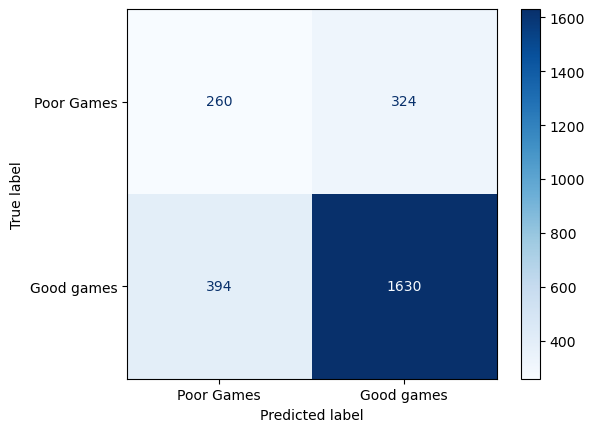

In [21]:
nb = MultinomialNB()

fit_score_(nb)

**Comments**:

Compared to baseline MNB using cvec_uniG_biG (precision 0.83, recall 0.76, specificity 0.48), this new approach, the model has same precision score, while having higher recall and poorer specificity (precision 0.83, recall 0.81, specificity 0.45).

> Overall, the improvement in True positive is much greater than the decline in specificity for True negative. As such, this model is more favoured to be used for addressing our business problem.

|Model|Description|Performance|
|---|---|---|
|Baseline Model<br>Multinomial Naive Bayes|Processes:<br> CountVectorizer|<li>Score to beat: 72% <li> Model Precision score: 79%|
|Approach 1:<br>Random Forest|Processes:<br> CountVectorizer|<li>Score to beat: 72% <li> Model Precision score: 73%|
|Approach 2:<br>Multinomial Naive Bayes<br>varying Vectorizer used|Processes:<br> CountVectorizer<br>TfidfVectorizer|<li>Score to beat: 72% <li> Models Precision score 72-76%|
|Approach 3:<br>Multinomial Naive Bayes<br>varying Vectorizer used<br> Limited to datasets with minimally 50 reviews|Processes:<br> CountVectorizer<br>TfidfVectorizer|<li>Score to beat: 77% <li> Models Precision score 77-83%|
|Approach 4:<br>Multinomial Naive Bayes<br>Excluding common NGrams tersm<br> Limited to datasets with minimally 50 reviews|Processes:<br> CountVectorizer|<li>Score to beat: 77% <li> Models Precision score 83%|

## 4.3 Exploring the approach with full data set
> - Include games regardless the number of reviews it has received (original dataset).
> - Using the same set of 'target_grams' to remove common NGrams across 'Good' and 'Poor' games

In [22]:
_df = df.copy()
X = _df['description']
y = _df['Good_Game']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, stratify=y) 

X_train = cvec.fit_transform(X_train)
X_train = pd.DataFrame(X_train.toarray(),
                       columns = cvec.get_feature_names_out())
print(f"Initial number of terms: {len(X_train.columns)}")

#removing columns with the terms found in target grams
X_train.drop(columns= X_train.columns[X_train.columns.isin(target_grams)],
            inplace=True)
print(f"After removing common target grams, the number of terms: {len(X_train.columns)}")

__df = pd.DataFrame(X_train.sum()).reset_index().rename(columns = {'index':'terms',0:'count'})
__df['gram_length'] = __df['terms'].str.split().str.len()

print(f"Types of Ngrams in X_train{__df['gram_length'].unique()}")
print(f"Lowest NGram's count {__df['count'].min()}")

Initial number of terms: 10000
After removing common target grams, the number of terms: 9681
Types of Ngrams in X_train[1 2 3]
Lowest NGram's count 32


In [23]:
#Apply the same process to X_test
X_test = cvec.transform(X_test)
X_test = pd.DataFrame(X_test.toarray(),
                      columns = cvec.get_feature_names_out())
X_test.drop(columns= X_test.columns[X_test.columns.isin(target_grams)],
            inplace=True)
X_test.shape

(6828, 9681)

y_train:
1    0.721205
0    0.278795
Name: Good_Game, dtype: float64

y_test:
1    0.721148
0    0.278852
Name: Good_Game, dtype: float64

Train accuracy score:0.7352668326741858
Test accuracy score:0.6873169302870533
Train f1 score:0.8108560664201493
Test f1 score:0.7785039941902688


              precision    recall  f1-score   support

           0       0.45      0.49      0.47      1904
           1       0.80      0.76      0.78      4924

    accuracy                           0.69      6828
   macro avg       0.62      0.63      0.62      6828
weighted avg       0.70      0.69      0.69      6828





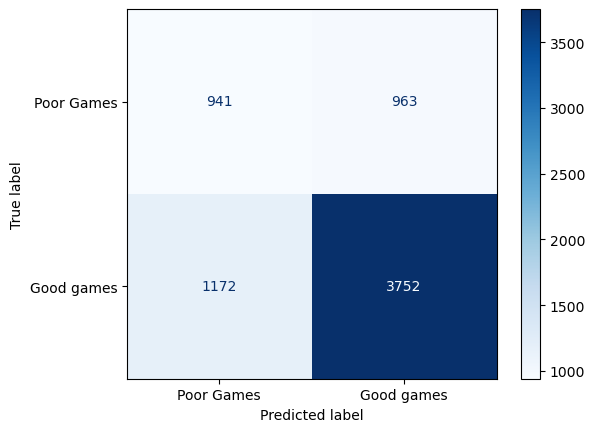

In [23]:
nb = MultinomialNB()

fit_score_(nb)

**Comments**:

Comparing the model performance to that baseline model MNB Naive, this model performed well with higher precision (0.80 vs 0.79), higher True Positive (3752 vs 3733) and Lower False Positive (963 vs 1018)! 

|Model|Description|Performance|
|---|---|---|
|Baseline Model<br>Multinomial Naive Bayes|Processes:<br> CountVectorizer|<li>Score to beat: 72% <li> Model Precision score: 79%|
|Approach 1:<br>Random Forest|Processes:<br> CountVectorizer|<li>Score to beat: 72% <li> Model Precision score: 73%|
|Approach 2:<br>Multinomial Naive Bayes<br>varying Vectorizer used|Processes:<br> CountVectorizer<br>TfidfVectorizer|<li>Score to beat: 72% <li> Models Precision score 72-76%|
|Approach 3:<br>Multinomial Naive Bayes<br>varying Vectorizer used<br> Limited to datasets with minimally 50 reviews|Processes:<br> CountVectorizer<br>TfidfVectorizer|<li>Score to beat: 77% <li> Models Precision score 77-83%|
|Approach 4.1:<br>Multinomial Naive Bayes<br>Excluding common NGrams tersm<br> Limited to datasets with minimally 50 reviews|Processes:<br> CountVectorizer|<li>Score to beat: 77% <li> Models Precision score 83%|
|Approach 4.2:<br>Multinomial Naive Bayes<br>Excluding common NGrams tersm|Processes:<br> CountVectorizer|<li>Score to beat: 72% <li> Models Precision score 80%|

# Approach 5: Let's further explore Approach 4 onto few other models

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB

## 5.1 KNeighborsClassifier

y_train:
1    0.721205
0    0.278795
Name: Good_Game, dtype: float64

y_test:
1    0.721148
0    0.278852
Name: Good_Game, dtype: float64

Train accuracy score:0.7814071578536205
Test accuracy score:0.6072056239015817
Train f1 score:0.8512377471340754
Test f1 score:0.7245275267050123


              precision    recall  f1-score   support

           0       0.31      0.33      0.32      1904
           1       0.73      0.72      0.72      4924

    accuracy                           0.61      6828
   macro avg       0.52      0.52      0.52      6828
weighted avg       0.61      0.61      0.61      6828





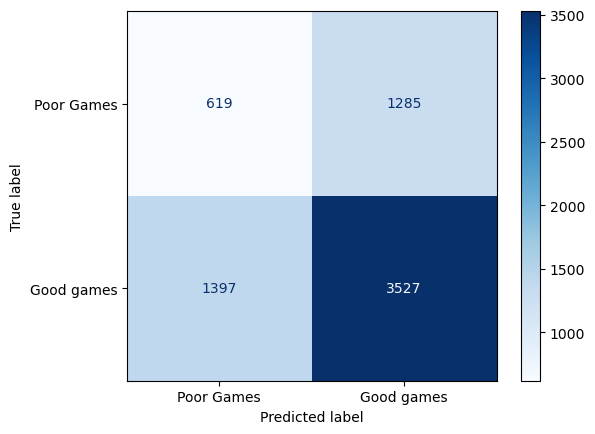

In [26]:
knn =  KNeighborsClassifier()
fit_score_(knn)

## 5.2 LogisticRegressionCV

y_train:
1    0.721205
0    0.278795
Name: Good_Game, dtype: float64

y_test:
1    0.721148
0    0.278852
Name: Good_Game, dtype: float64

Train accuracy score:0.7606073922171769
Test accuracy score:0.7240773286467487
Train f1 score:0.856212792163993
Test f1 score:0.8348816827344434


              precision    recall  f1-score   support

           0       0.53      0.10      0.16      1904
           1       0.73      0.97      0.83      4924

    accuracy                           0.72      6828
   macro avg       0.63      0.53      0.50      6828
weighted avg       0.68      0.72      0.65      6828





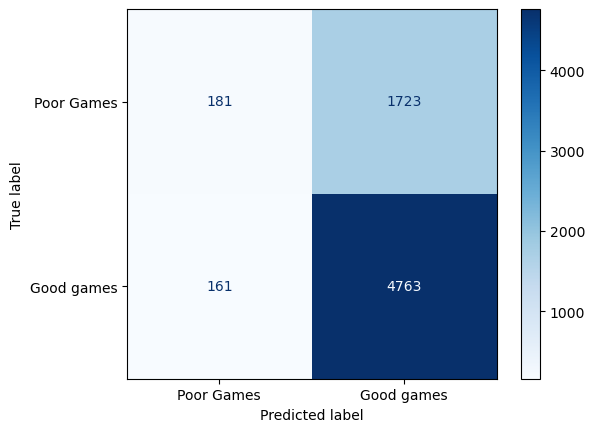

In [27]:
log_r = LogisticRegressionCV(max_iter=10000)
fit_score_(log_r)

## 5.3 Complement Naive Bayes with different alpha values

y_train:
1    0.721205
0    0.278795
Name: Good_Game, dtype: float64

y_test:
1    0.721148
0    0.278852
Name: Good_Game, dtype: float64

Train accuracy score:0.7208144133587228
Test accuracy score:0.6685705916813123
Train f1 score:0.7923143977916607
Test f1 score:0.7544221378187738


              precision    recall  f1-score   support

           0       0.43      0.57      0.49      1904
           1       0.81      0.71      0.75      4924

    accuracy                           0.67      6828
   macro avg       0.62      0.64      0.62      6828
weighted avg       0.70      0.67      0.68      6828





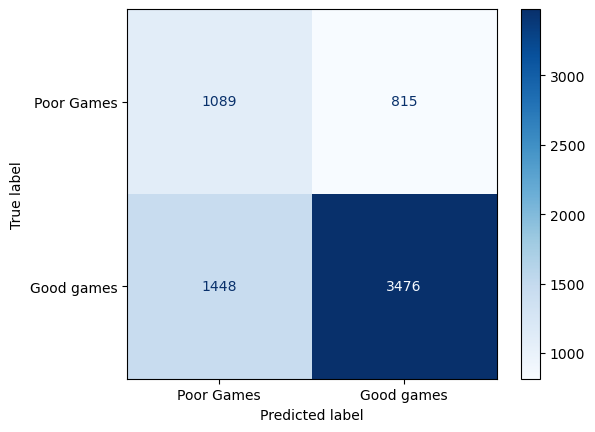

y_train:
1    0.721205
0    0.278795
Name: Good_Game, dtype: float64

y_test:
1    0.721148
0    0.278852
Name: Good_Game, dtype: float64

Train accuracy score:0.7234998291099067
Test accuracy score:0.6694493263034563
Train f1 score:0.7946179233307946
Test f1 score:0.755126396875339


              precision    recall  f1-score   support

           0       0.43      0.57      0.49      1904
           1       0.81      0.71      0.76      4924

    accuracy                           0.67      6828
   macro avg       0.62      0.64      0.62      6828
weighted avg       0.70      0.67      0.68      6828





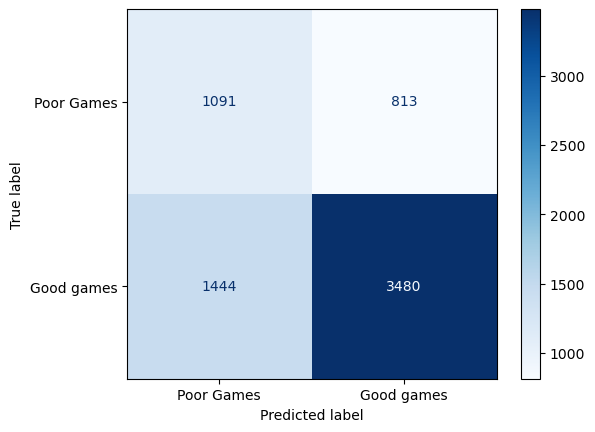

y_train:
1    0.721205
0    0.278795
Name: Good_Game, dtype: float64

y_test:
1    0.721148
0    0.278852
Name: Good_Game, dtype: float64

Train accuracy score:0.723841609296421
Test accuracy score:0.669302870533099
Train f1 score:0.7949387281560438
Test f1 score:0.7550444781948361


              precision    recall  f1-score   support

           0       0.43      0.57      0.49      1904
           1       0.81      0.71      0.76      4924

    accuracy                           0.67      6828
   macro avg       0.62      0.64      0.62      6828
weighted avg       0.70      0.67      0.68      6828





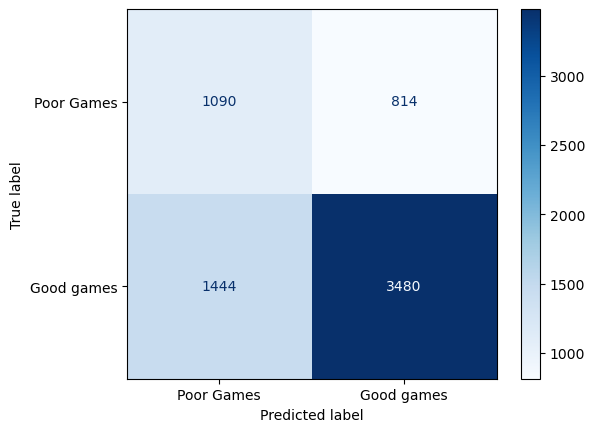

In [28]:
C_nb = ComplementNB()
fit_score_(C_nb)
C_nb = ComplementNB(alpha=0.1)
fit_score_(C_nb)
C_nb = ComplementNB(alpha=0.01)
fit_score_(C_nb)

**Comments**

- Our latest model <code>*C_nb = ComplementNB(alpha=0.01)*</code>, seemed to have the greatest performance! With precision of 0.81, recall of 0.71 and specificity of 0.57.

Here is a summary of the key models we have in this project:

|Model|Description|Performance|
|---|---|---|
|Baseline Model<br>Multinomial Naive Bayes|Processes:<br> CountVectorizer|<li>Score to beat: 72% <li> Model Precision score: 79%|
|Approach 1:<br>Random Forest|Processes:<br> CountVectorizer|<li>Score to beat: 72% <li> Model Precision score: 73%|
|Approach 2:<br>Multinomial Naive Bayes<br>varying Vectorizer used|Processes:<br> CountVectorizer<br>TfidfVectorizer|<li>Score to beat: 72% <li> Models Precision score 72-76%|
|Approach 3:<br>Multinomial Naive Bayes<br>varying Vectorizer used<br> Limited to datasets with minimally 50 reviews|Processes:<br> CountVectorizer<br>TfidfVectorizer|<li>Score to beat: 77% <li> Models Precision score 77-83%|
|Approach 4:<br>Multinomial Naive Bayes<br>Excluding common NGrams tersm|Processes:<br> CountVectorizer|<li>Score to beat: 72% <li> Models Precision score 80%|
|Approach 5:<br>Complement Naive Bayes<br>Excluding common NGrams tersm|Processes:<br> CountVectorizer|<li>Score to beat: 72% <li> Models Precision score 81%|


# Post-modelling analysis: Does Game Description's word count after model's prediction performance?

We suspect that the false prediction is due to the limited word count in some game description. Let's examine this suspicion by comparing the description word count between the 'Correctly predicted' games and 'Wrongly predicted' games.

In [52]:
#Our selected model for our business problem:
_df = df.copy()
X = _df['description']
y = _df['Good_Game']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, stratify=y) 

X_test_copy = X_test.copy()

X_train = cvec.fit_transform(X_train)
X_train = pd.DataFrame(X_train.toarray(),
                       columns = cvec.get_feature_names_out())
X_train.drop(columns= X_train.columns[X_train.columns.isin(target_grams)],
            inplace=True)

X_test = cvec.transform(X_test)
X_test = pd.DataFrame(X_test.toarray(),
                      columns = cvec.get_feature_names_out())
X_test.drop(columns= X_test.columns[X_test.columns.isin(target_grams)],
            inplace=True)

C_nb = ComplementNB(alpha=0.1)
C_nb.fit(X_train, y_train)

y_pred = C_nb.predict(X_test)

precision_score(y_test, y_pred)

ComplementNB(alpha=0.1)

0.8106219426974144

In [86]:
__df = pd.DataFrame(y_test)
__df.reset_index(inplace=True,drop=True)
__df.rename(columns = {'Good_Game':'y_test_true'},inplace=True)               
__df['y_test_predict'] = y_pred

X_test_copy.reset_index(inplace=True,drop=True)

__df['X_test_copy'] = X_test_copy
__df

,y_test_true,y_test_predict,X_test_copy
0,0,0,school owner is a construction and management ...
1,0,1,you need to get to know the girl and get in to...
2,1,1,in frame of mind you are placed in a world whe...
3,1,1,phantom abyss is a massive asynchronous multip...
4,0,0,covid chaos is an action packed space shooter ...
...,...,...,...
6823,0,0,isnt it a shame that there are all these hot u...
6824,1,1,fire up the chainsaw just because youre dead d...
6825,1,1,pink island is a one small hold gun boss rush...
6826,1,0,spectral ascension is a freetoplay fast paced ...


In [88]:
#creating a columns that contains the Game Descriptions' word count
__df['word_count'] = __df['X_test_copy'].str.split().apply(len)
__df['word_count']

0       170
1        36
2       113
3       376
4        58
       ... 
6823    217
6824    345
6825     27
6826     63
6827     85
Name: word_count, Length: 6828, dtype: int64

In [89]:
#let's look at the statistic description of the word count
__df['word_count'].describe().round()

count    6828.0
mean      213.0
std       164.0
min         2.0
25%       110.0
50%       173.0
75%       270.0
max      3266.0
Name: word_count, dtype: float64

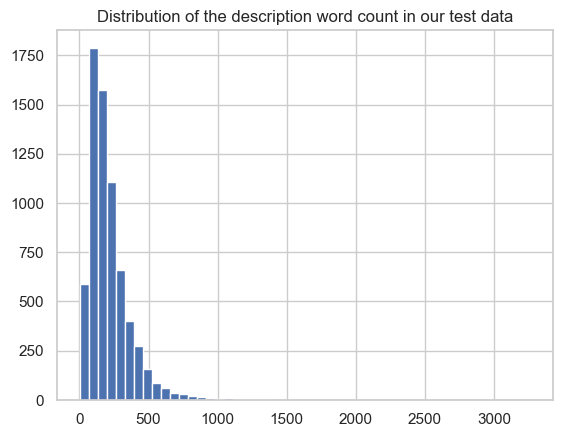

In [90]:
#Lets view the distrit
plt.hist(__df['word_count'],bins=50);
plt.title('Distribution of the description word count in our test data');

In [91]:
print(f"Number of test data with description <= 100 word count: {len(__df[__df['word_count']<=100])}")
print(f"Percentage of test data with description <= 100 word count: {round((len(__df[__df['word_count']<=100])/len(__df)),2)}")

Number of test data with description <= 100 word count: 1444
Percentage of test data with description <= 100 word count: 0.21


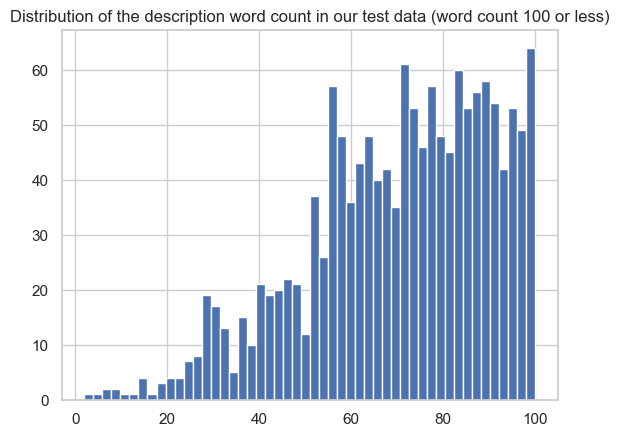

In [92]:
plt.hist(__df.loc[__df['word_count']<=100,'word_count'],bins=50);
plt.title('Distribution of the description word count in our test data (word count 100 or less)');

## Let's compare word count between 'Correctly predicted games' and 'Falsely predicted games'

In [111]:
__df['prediction'] =  (__df['y_test_true']==__df['y_test_predict']).astype(int)
__df['prediction'] = np.where(__df['prediction'] == 1, 'Correct prediction', 'False prediction')

In [114]:
__df.groupby('prediction')['word_count'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
prediction,,,,,,,,
Correct prediction,4571.0,205.62,156.96,2.0,109.0,170.0,256.0,3266.0
False prediction,2257.0,229.39,175.81,7.0,112.0,179.0,292.0,1496.0


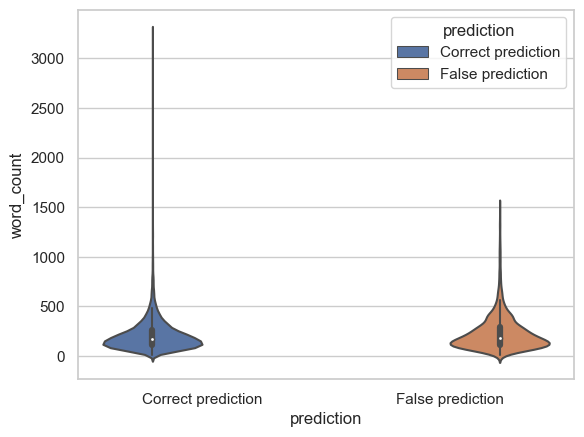

In [120]:
sns.violinplot(data=__df, x='prediction', y='word_count', hue='prediction');

**Comments**:

It appears that the distribution of game description word count does not differ significantlhy between the correctly and wrongly predicted games. 
> Perhaps, through further analysis of the common terms found between the correctly and wrongly predicted games, and between the 'Good' and 'Poor' games, we can further improve the models classifcation ability. 

# Discusssion and Conclussion:


|Model|Description|Performance|
|---|---|---|
|Baseline Model<br>Multinomial Naive Bayes|Processes:<br> CountVectorizer|<li>Score to beat: 72% <li> Model Precision score: 79%|
|Approach 1:<br>Random Forest|Processes:<br> CountVectorizer|<li>Score to beat: 72% <li> Model Precision score: 73%|
|Approach 2:<br>Multinomial Naive Bayes<br>varying Vectorizer used|Processes:<br> CountVectorizer<br>TfidfVectorizer|<li>Score to beat: 72% <li> Models Precision score 72-76%|
|Approach 3:<br>Multinomial Naive Bayes<br>varying Vectorizer used<br> Limited to datasets with minimally 50 reviews|Processes:<br> CountVectorizer<br>TfidfVectorizer|<li>Score to beat: 77% <li> Models Precision score 77-83%|
|Approach 4:<br>Multinomial Naive Bayes<br>Excluding common NGrams tersm|Processes:<br> CountVectorizer|<li>Score to beat: 72% <li> Models Precision score 80%|
|Approach 5:<br>Complement Naive Bayes<br>Excluding common NGrams tersm|Processes:<br> CountVectorizer|<li>Score to beat: 72% <li> Models Precision score 81%|

Our final selected best model (Complemet Naive Bayes) improve the investors chance of investing in 'Good' games from default probability of 72% to 81%.

**Limitation**
1. Limited number of reviews (e.g. <50 reviews) may have insufficient to determine if a game is 'Good' or 'Poor'. However, by limiting the dataset to only games with at least a certain number of reviews will significantly reduce the number of available dataset available for analysis and model training.
    - There need to be a balance between the accuracy of labelling a game as 'Good' or 'Poor' and having enough dataset for training model to do differentiate a 'Good' and 'Poor' game.
    - In our final selected model, we worked around this challenge by analysing common terms found in the two classes of games by focusing only on games with at least 50 reviews. We subsequently applied that resulting model approach and target terms filtering on the entire dataset which gave us our best performace.
    - Analysis could have been on comparing the games total number of reviews between correctly and wrong predicted games.
1. Game industry is ever-changing, the model will have to be revised to capture new and upcoming trends.
1. Some features that can greatly determines a game's success may not be captured in the game's description,such as game developers and programmers.
    - such features can be explored and analysed to incorporated to improve model performance.
1. The game has poor specificity (~50%); it is not able to pick up actual poor games well.
    - This is due to lack of information the model needs to identify a game that is actually poor.
    - Features of poor games may be explored and obtained through examining games' negative reviews itself. User's description of why they find a game is 'bad' can give insights on improving the model's ability to detect actual 'True Negatives'
    
**Conclusion**:<br>
Recognising our model's strengths and flaws, what does this mean for our model?<br> What is it place of use in the business context?

> - Investors should use the model to identify potential games for investing while recognising it does not capture other important information making the ultimate call whether a game should be invested or not.
> - The model ultimately narrows down the canditates of games for further consideration for investing, which makes the selection phase much more efficient.
> - While this would mean some opportunity cost (due to False Negative predictions), it is worth noting that it can be overcome by setting a target number of games to invest in, and achieving that target number while being able to save time and resources in the selection and decision making process.